In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import math
from scipy.optimize import curve_fit


In [2]:
#Functions
def alpha(z):
    return np.sin(np.pi * z / 2)
def dBr_dz(B_r):
    return np.gradient(B_r, dz)
def d2Br_dz2(B_r):
    return np.gradient(np.gradient(B_r, dz), dz)
def d2Bphi_dz2(B_phi):
    return np.gradient(np.gradient(B_phi, dz), dz)
def dBrdt(eta_t,B_r, B_phi):
    return - (h * alpha_0 / eta_t) * dBr_dz(B_phi * alpha(z)) + d2Br_dz2(B_r)
def dBphidt(eta_t,B_r, B_phi):
    return - (h**2 * q * Omega / eta_t) * B_r + d2Bphi_dz2(B_phi)

def rk4_step(B_r, B_phi,eta_t):
    k1_r = dt * dBrdt(eta_t,B_r, B_phi)    
    k1_phi = dt * dBphidt(eta_t,B_r, B_phi)    
    
    k2_r = dt * dBrdt(eta_t,B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    k2_phi = dt * dBphidt(eta_t,B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    
    k3_r = dt * dBrdt(eta_t,B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)
    k3_phi = dt * dBphidt(eta_t,B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)    
    
    k4_r = dt * dBrdt(eta_t,B_r + k3_r, B_phi + k3_phi)    
    k4_phi = dt * dBphidt(eta_t,B_r + k3_r, B_phi + k3_phi)
    
    B_r_new = B_r + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
    B_phi_new = B_phi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6
    
    B_r_new[0] = 0
    B_r_new[-1] = 0
    B_phi_new[0] = 0
    B_phi_new[-1] = 0
    
    return B_r_new, B_phi_new
def initial_condition(x):
    return np.sin(np.pi *((x+L)/(2*L)))
def update_plot1(frame):
    global B_r0, B_phi0,BrvT,BphivT
    B_r0, B_phi0 = rk4_step(B_r0, B_phi0,eta_t)
    BrvT[frame,:]=B_r0.copy()
    BphivT[frame,:]=B_phi0.copy()
    line_br.set_ydata(B_r0)
    line_bphi.set_ydata(B_phi0)
    ax.set_title(f'Time = {(frame+1) * 100 * dt:.2f}')
    min_B = np.min([np.min(B_r0), np.min(B_phi0)])
    max_B = np.max([np.max(B_r0), np.max(B_phi0)])
    ax.set_ylim(1.1*min_B , 1.1*max_B)    
    return line_br, line_bphi
split_index=50
def split_index_gamma(split_index=50):
    b_fit=[]
    b_fit2=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
    log_B = np.log(b_fit)
    log_B2=np.log(b_fit2)
    Tlis = np.linspace(0, T, time_step)
    slope1, intercept1 = interceptandslope(Tlis[:split_index], log_B[:split_index])
    slope2, intercept2 = interceptandslope(Tlis[split_index:], log_B[split_index:])
    print("Slope of the first segment:", slope1)#these are local slopes in time
    print("Slope of the second segment:", slope2)

    plt.plot(Tlis, log_B, label="log B at z=0")
    plt.plot(Tlis[:split_index], slope1 * Tlis[:split_index] + intercept1, color='red', label=f"Slope 1: {slope1:.5f}")
    plt.plot(Tlis[split_index:], slope2 * Tlis[split_index:] + intercept2, color='green', label=f"Slope 2: {slope2:.5f}")

    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
def onevarsum(a):#finds sum of 1 variable
    sum1=0
    for i in range(len(a)):
        sum1+=a[i]
    return sum1
def twovarsum(a,b):
    sum1=0
    for i in range(len(a)):
        sum1+=(a[i]*b[i])
    return sum1
def interceptandslope(x,y):#least square fit
    s=len(x)
    sx=onevarsum(x)
    sxx=twovarsum(x,x)
    sy=onevarsum(y)
    sxy=twovarsum(x,y)
    delt=(s*sxx-(sx**2))
    intercept=(sxx*sy-sx*sxy)/delt
    slop=(sxy*s-sx*sy)/delt
    errslope=(s/delt)**0.5
    errinter=(sxx/delt)**0.5
    return(slop,intercept)#,errinter,errslope
def get_gamma(BrvT,BphivT):
    b_fit=[]
    b_fit2=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
    """def exponential_func(t, B0, gamma):
        return B0 * np.exp(gamma * t)
    
    popt, pcov = curve_fit(exponential_func, Tlis, b_fit)
    popt1, pcov1 = curve_fit(exponential_func, Tlis, b_fit2)    
    print("Gamma from fit for B_r:", popt[1])#global fit
    print("Gamma from fit for B_phi:", popt1[1])
    gamma=popt[1]"""
    log_B = np.log(b_fit)
    log_B2=np.log(b_fit2)
    Tlis = np.linspace(0, T, time_step)
    slop1,_=interceptandslope(Tlis,log_B)
    slop2,_=interceptandslope(Tlis,log_B2)
    print("Gamma from linear fit for B_r:", slop1)#global fit
    print("Gamma from linear fit for B_phi:", slop2)
    plt.plot(Tlis,log_B,label=f"$B_r$ $\gamma$={slop1:.6f}")    
    plt.plot(Tlis,log_B2,label=f"$B_\phi$ $\gamma$={slop2:.6f}")
    
    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
    

Dynamo Number: -0.1


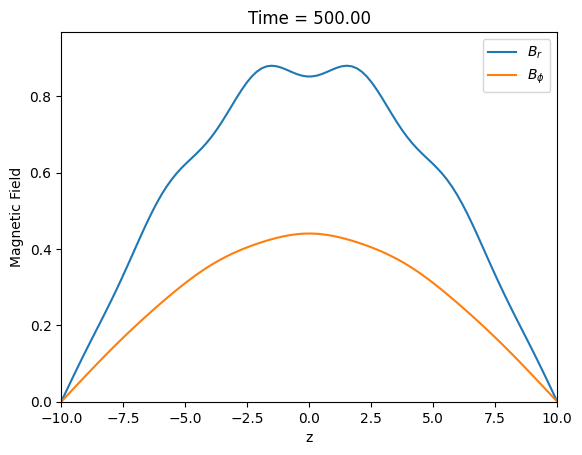

In [3]:
# Parameters
h = 1.0   
alpha_0 = 1.0  
q = 1.0   
Omega = 1.0  
eta_t = 10.0
t0=1.0
#grid parameters
L = 10.0  
N = 100   
dt = 0.01 
T = 500
time_step = int(T / (100 * dt))
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)
B_phi0=initial_condition(z)
#changing to dimensionless units

Tlis=Tlis/t0
z=z/h
alpha_0=alpha_0*t0/h
Omega=Omega*t0

BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(-L, L)
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'magnetic_field_evolution(T={T}).gif', writer='pillow')
plt.show()


Gamma from linear fit for B_r: -0.00023518106836322973
Gamma from linear fit for B_phi: -0.001609064495071738


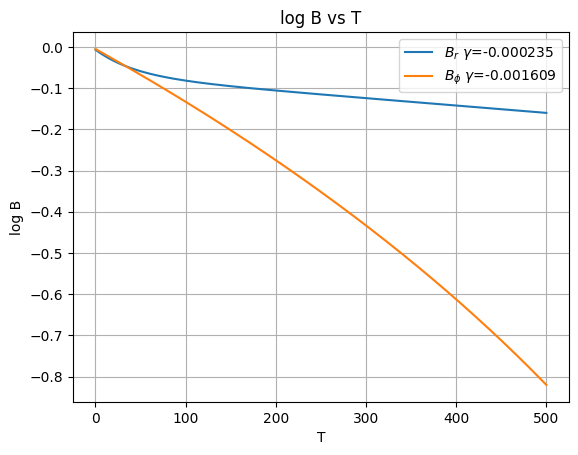

In [4]:
get_gamma(BrvT,BphivT)

Slope of the first segment: -0.0010176474585494176
Slope of the second segment: -0.00020000257810292102


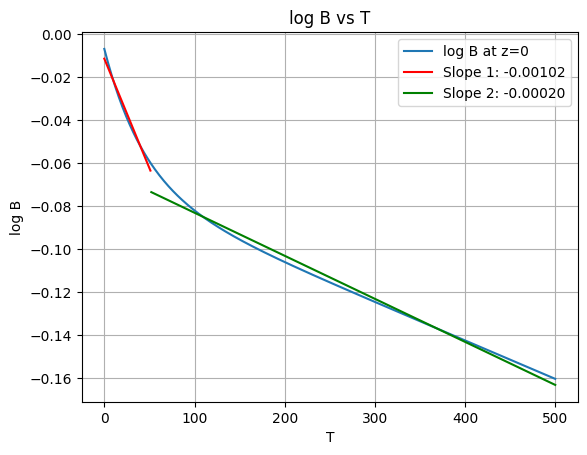

In [5]:
split_index_gamma(52)

In [11]:
def find_critical_D_n(Eta_lis):
    Eta_for_dynamo_numbers=[]#only notes dynamo numbers where norm increases
    for eta1 in Eta_lis:
        norm_b=[]
        eta_t=eta1
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)
        BrvT =np.zeros((time_step,N))
        BphivT = np.zeros((time_step,N))
        
        for k in range(0,time_step):
            B_r0, B_phi0 = rk4_step(B_r0, B_phi0,eta_t) 
            BrvT[k,:]=B_r0.copy()
            BphivT[k,:]=B_phi0.copy() 
        #mag_B_r_phi = np.sqrt(B_r0 ** 2 + B_phi0 ** 2)#if this value decreases we can say that the dynamo is decaying and thus is not growing
        #norm_b.append(mag_B_r_phi)
        #print(eta1)
        #print(BrvT[25])
        #print(norm_b)
        index=len(BrvT[0])//2
        for i in range(10,len(BrvT),10):
            norm_b_value=(BrvT[i][index]**2+BphivT[i][index]**2)**(0.5)
            norm_b.append(norm_b_value)
        c=0
        for j in range(len(norm_b)//2,len(norm_b)):
            if norm_b[j]>=norm_b[j-1]:
                Eta_for_dynamo_numbers.append(eta1)
                break
        else:
            pass
            #print(f"for eta_t = {eta1}; the dynamo undergoes exponential decay")
    
    return max(Eta_for_dynamo_numbers)
eta_t_values = np.linspace(0.01,10.0,99)
eta_mp=find_critical_D_n(eta_t_values)
index2=np.where(eta_t_values==eta_mp)
eta_t_values_2 = np.linspace(eta_t_values[index2],eta_t_values[index2+1],100)
eta_m=find_critical_D_n(eta_t_values_2)

critical_dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_m
print(f"Maximum Eta is {eta_m}. This gives critical dynamo number as {critical_dynamo_number}.")

C:\Users\DeLL\AppData\Local\Temp\ipykernel_6232\1247984200.py:22: RuntimeWarning: overflow encountered in scalar power
  norm_b_value=(BrvT[i][index]**2+BphivT[i][index]**2)**(0.5)


Maximum Eta is 4.903061224489796.


In [12]:
import numpy as np

# Example array
arr = np.array([1, 2, 3, 4, 5])

# Value to find
value = 3

# Find index of value in array
index = np.where(arr == value)

# Print the index
print("Index of", value, ":", index[0])


Index of 3 : [2]
